# Generating Synthetic PSDs for training

In [1]:
! pip install keras
! pip install tensorflow


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [13]:
! pip install ydata-synthetic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 454.1 kB/s eta 0:00:000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.4 MB/s eta 0:00:0000:0100:06
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 2.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 490.5 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 1.2 MB/s eta 0:0

In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Get PSDs from O3a real noise for augmentation

In [3]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import os
import csv
import h5py
import requests
import numpy as np
import ligo.segments

from pycbc import DYN_RANGE_FAC
import scipy.signal as ss
import matplotlib.pyplot as plt

In [6]:
class NoiseSlice():
    """ Used to augment the start time of noise samples from continuous noise .hdf file """
    # This will become the primary noise reading function
    def __init__(self, real_noise_path="", sample_length=20.0):
        self.sample_length = sample_length
        self.min_segment_duration = self.sample_length
        self.real_noise_path = real_noise_path
        self.segment_ends_buffer = 0.0 # seconds
        self.slide_buffer = 240.0
        self.dt = 1./2048.

        save = []

        # Keep all required noise files open
        self.O3a_real_noise = h5py.File(self.real_noise_path, 'r')
        # Get detectors used
        self.detectors = ['H1', 'L1']
        # Get ligo segments and load_times from noise file
        ligo_segments, load_times = self._get_ligo_segments()
        # Get segment info and set probability of obtaining sample from segment
        self.psegment = {}
        segdurs = np.empty(len(ligo_segments), dtype=np.float64)
        for n, seg in enumerate(ligo_segments):
            key_time = str(load_times[seg][0])
            _key = f'{self.detectors[0]}/{key_time}'
            # Sanity check if _key is present in noise file
            try:
                _ = self.O3a_real_noise[_key]
            except:
                # An impossible segment duration and cond rand < segprob is never satisfied
                segdurs[n] = 0
                self.psegment[n] = [-1, -1, -1]
                continue
            
            # Set valid start and end times of given segment (not actual start time)
            # load_times[seg][0] is the same as seg[0]
            segment_length = len(np.array(self.O3a_real_noise[_key][:]))
            seg_start_idx = 0 + self.segment_ends_buffer
            seg_end_idx = segment_length - (self.sample_length + self.segment_ends_buffer)*(1./self.dt)
            # Get segment duration for calculating sampling ratio wrt all segments
            segdurs[n] = segment_length
            save.append([float(key_time), float(segment_length)])
            # Add the epoch parameter to store
            self.psegment[n] = [key_time, seg_start_idx, seg_end_idx]

        # Save segment lengths
        np.save("./segdurs.npy", save)

        # Get probabilties of using segment using segment durations
        self.seg_idx = np.arange(len(segdurs))
        # segprob = list(segdurs/np.sum(segdurs))
        segprob = [1./len(segdurs)]*len(segdurs)
        # Get one choice from seg_idx based on probalities obtained from seg durations
        self.segment_choice = lambda _: np.random.choice(self.seg_idx, 1, p=segprob)[0]

    def _load_segments(self):
        tmp_dir = "./tmp"
        path = os.path.join(tmp_dir, 'segments.csv')
        # Download data if it does not exist
        if not os.path.isfile(path):
            url = 'https://www.atlas.aei.uni-hannover.de/work/marlin.schaefer/MDC/segments.csv'
            response = requests.get(url)
            with open(path, 'wb') as fp:
                fp.write(response.content)

        # Load data from CSV file
        segs = ligo.segments.segmentlist([])
        with open(path, 'r') as fp:
            reader = csv.reader(fp)
            for i, row in enumerate(reader):
                if i == 0:
                    continue
                idx, start, end = row
                segs.append(ligo.segments.segment([int(start), int(end)]))

        return segs
    
    def _get_ligo_segments(self):
        # https://lscsoft.docs.ligo.org/ligo-segments/
        segments = self._load_segments()
        
        # Restrict segments
        ligo_segments = ligo.segments.segmentlist([])
        for seg in segments:
            start, end = seg
            segduration = end - start
            # Check if segment fulfills minimum duration requirements
            if self.min_segment_duration is not None and segduration - self.slide_buffer < self.min_segment_duration:
                continue
            ligo_segments.append(ligo.segments.segment([start, end]))
        
        # Refer link provided above to ligo-segments
        # Sort the elements of the list into ascending order, and merge continuous 
        # segments into single segments. Segmentlist is modified in place. 
        # This operation is O(n log n).
        ligo_segments.coalesce()

        # Get times from each valid segment
        load_times = {}
        for seg in ligo_segments:
            for rawseg in segments:
                if seg in rawseg:
                    load_times[seg] = rawseg
                    break;
            if seg not in load_times:
                raise RuntimeError
            
        return ligo_segments, load_times
    
    def _make_sample_start_time(self, seg_start_idx, seg_end_idx):
        # Make a sample start time that is uniformly distributed within segdur
        return int(np.random.uniform(low=seg_start_idx, high=seg_end_idx))

    def get_noise_segment(self, segdeets):
        ## Get noise sample from given O3a real noise segment
        noise = []
        for det, segdeet in zip(self.detectors, segdeets):
            key_time, seg_start_idx, seg_end_idx = segdeet
            # Get sample_start_time using segment times
            # This start time will lie within a valid segment time interval
            sample_start_idx = self._make_sample_start_time(seg_start_idx, seg_end_idx)
            # Get the required portion of given segment
            sidx = sample_start_idx
            eidx = sample_start_idx + int(self.sample_length / self.dt)
            # Which key does the current segment belong to in real noise file
            # key_time provided is the start time of required segment
            key = f'{det}/{key_time}'
            # Get time series from segment and apply the dynamic range factor
            ts = np.array(self.O3a_real_noise[key][sidx:eidx]).astype(np.float64)
            if "O3a_real_noise.hdf" in self.real_noise_path:
                ts /= DYN_RANGE_FAC
            noise.append(ts)
        
        # Convert noise into np.ndarray, suitable for other transformations
        noise = np.stack(noise, axis=0)
        return noise
    
    def pick_segment(self):
        # Pick a random segment to use based on probablities set using their duration
        # Picking two different segments and start times provides an extra layer of augmentation
        # idx1 = self.segment_choice(0)
        # idx2 = self.segment_choice(0)
        idx1 = self.seg_idx[0]
        idx2 = self.seg_idx[-1]
        # Return the segment details of selected segment
        return (self.psegment[idx1], self.psegment[idx2])

    def apply(self):
        ## Get noise sample with random start time from O3a real noise
        # Toss a biased die and retrieve the segment to use
        segdeets = self.pick_segment()
        # Get noise sample with random start time (uniform within segment)
        noise = self.get_noise_segment(segdeets)
        # Return noise data
        return noise


In [4]:
data = np.load('../tmp/segdurs.npy')
key_times = data[:,0]
segdurs = data[:,1]
print(data)

[[1.23820508e+09 2.06049280e+07]
 [1.23840037e+09 2.27102720e+07]
 [1.23854655e+09 1.82476800e+07]
 [1.23856118e+09 6.20072960e+07]
 [1.23861262e+09 1.50446080e+07]
 [1.23864591e+09 5.48618240e+07]
 [1.23867759e+09 2.04820480e+07]
 [1.23873147e+09 5.47389440e+07]
 [1.23875828e+09 2.01236480e+07]
 [1.23880551e+09 2.78200320e+07]
 [1.23881985e+09 2.81088000e+07]
 [1.23883463e+09 3.95776000e+07]
 [1.23891897e+09 2.33922560e+07]
 [1.23899684e+09 2.11783680e+07]
 [1.23906018e+09 1.82108160e+07]
 [1.23906967e+09 2.57556480e+07]
 [1.23908714e+09 3.29318400e+07]
 [1.23915385e+09 3.01998080e+07]
 [1.23916863e+09 4.17914880e+07]
 [1.23920148e+09 1.49790720e+07]
 [1.23921362e+09 1.52391680e+07]
 [1.23944942e+09 1.85180160e+07]
 [1.23967209e+09 2.80924160e+07]
 [1.23979502e+09 2.44961280e+07]
 [1.24026641e+09 1.83357440e+07]
 [1.24028524e+09 3.64912640e+07]
 [1.24030583e+09 4.40115200e+07]
 [1.24036086e+09 2.11599360e+07]
 [1.24037489e+09 4.89123840e+07]
 [1.24039886e+09 5.47840000e+07]
 [1.240554

In [5]:
O3a_real_noise = h5py.File("/local/scratch/igr/nnarenraju/O3a_real_noise/O3a_real_noise_alt.hdf", 'r')

In [6]:
tss = []
times = []
for key_num in range(len(key_times)):
    det = 'H1'
    key = f'{det}/{int(key_times[key_num])}'
    sidx = 0
    eidx = int(sidx + (10. * 2048.))
    for i in range(13):
        times.append(int(key_times[key_num]))
        offset = int(2**(9+i)) if i > 0 else 0
        d = np.array(O3a_real_noise[key][sidx+offset:eidx+offset]).astype(np.float64) / DYN_RANGE_FAC
        tss.append(d)

print(tss[0].shape)
tss = np.array(tss)
print(tss.shape)

(20480,)
(4706, 20480)


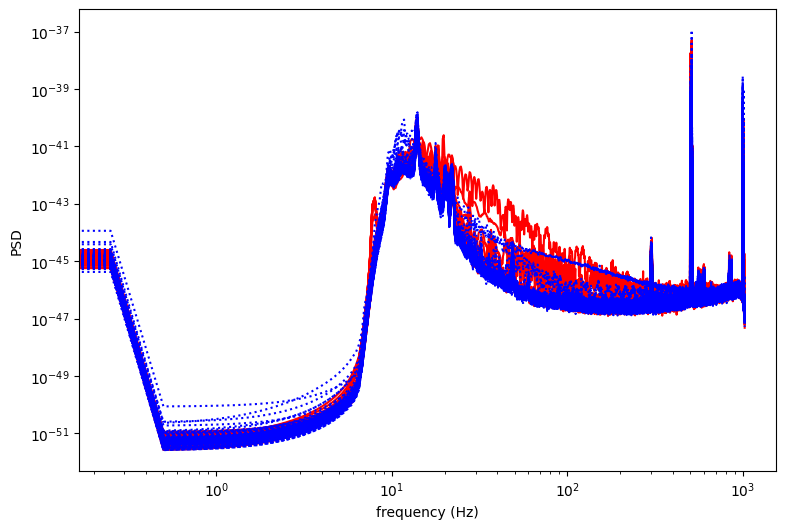

In [10]:
check = int((3./8.) * len(key_times))
fs = 2048.
plt.figure(figsize=(9.0, 6.0))

dff = 0.005
meds = {i:[] for i in range(int(1./dff))}
med_times = {i:[] for i in range(int(1./dff))}
for n, (ts, time) in enumerate(zip(tss, times)):
    freq_psd, p_welch = ss.welch(ts, fs=fs, nperseg=4*fs, average='median')
    for i in range(int(1./dff)):
        if n < tss.shape[0] * dff*(i+1) and n >= tss.shape[0] * dff*i:
            meds[i].append(p_welch)
            med_times[i].append(time)

for n, med in meds.items():
    med = np.mean(med, axis=0)
    med_time = np.min(med_times[n])
    if med_time < key_times[check]:
        plt.loglog(freq_psd, med, ls='solid', label='Section {}'.format(n), color='red')
    else:
        plt.loglog(freq_psd, med, ls='dotted', label='Section {}'.format(n), color='blue')

plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.savefig('./PSDs.png')

In [11]:
foobar = [np.array(foo) for foo in meds.values()]
foobar = np.row_stack((foobar))
print(foobar.shape)

(4706, 4097)


In [12]:
# Reshape to be suitable input for timeGAN
psds_h1 = np.reshape(foobar, (foobar.shape[0], foobar.shape[1], 1))
print(psds_h1.shape)

(4706, 4097, 1)


### Training a TimeGAN via ydata-synthetic package

In [14]:
# Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

2024-01-25 18:34:18.426842: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 18:34:18.664084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 18:34:18.665221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 18:34:20.163620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f578dbf6160>
Traceback (most recent call last):
  File "/home/nnarenraju/Research/ORChiD/DEBUGGING/ML-GWSC1-Glasgow/source/baseline

TypeError: unsupported operand type(s) for |: 'types.GenericAlias' and 'NoneType'